# Trabalho 2 de Inteligência Artificial

Gabriel Willye Borges Valençoela

## Instalação das dependências

In [ ]:
!pip install plotly
!pip install keras
!pip install streamlit

## Importar bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

## Carregar o dataset do MNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 49730343.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1748595.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12619341.68it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3533765.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Definir a arquitetura da rede neural convolucional (CNN)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def feat_extractor(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return x

    def forward(self, x):
        x = self.feat_extractor(x)
        x = self.fc2(x)
        return x

## Definir função para treinar a rede

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


## Definir a função para extrair as features da rede neural

In [ ]:
def extract_features(model, device, loader):
    model.eval()
    features = []
    labels = []
    images = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            feature = model.feat_extractor(data)
            features.append(feature.cpu().numpy())
            labels.append(target.cpu().numpy())
            images.append(data.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    images = np.concatenate(images)
    print(features)
    return features, labels, images

## Definir função para visualizar T-SNE

In [ ]:
def visualize_tsne(features, labels):
    tsne = TSNE(n_components=3, random_state=0)
    tsne_result = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('TSNE visualization')
    plt.show()

## Definir função para clustering e avaliação

In [ ]:
# Função para clustering e avaliação
def clustering_and_evaluation(features, labels):
    kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
    kmeans_labels = kmeans.fit_predict(features)
    silhouette_avg_kmeans = silhouette_score(features, kmeans_labels)
    print(f'Silhouette Score for KMeans: {silhouette_avg_kmeans}')

    hierarchical = AgglomerativeClustering(n_clusters=10)
    hierarchical_labels = hierarchical.fit_predict(features)
    silhouette_avg_hierarchical = silhouette_score(features, hierarchical_labels)
    print(f'Silhouette Score for Hierarchical Clustering: {silhouette_avg_hierarchical}')

    return kmeans_labels, hierarchical_labels


## Definir função para plotar exemplos confusos

In [ ]:
def plot_confusing_examples(images, labels, kmeans_labels):
    for i in range(10):
        cluster_indices = np.where(kmeans_labels == i)[0]
        cluster_labels = labels[cluster_indices]
        if len(np.unique(cluster_labels)) > 1:
            print(f'Cluster {i} has examples from multiple classes: {np.unique(cluster_labels)}')
            example_indices = cluster_indices[:5]
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))
            for idx, ax in zip(example_indices, axes):
                ax.imshow(images[idx][0].reshape(28, 28), cmap='gray')
                ax.axis('off')
            plt.show()

## Função para Plot de Gráfico em 3D

In [ ]:
import plotly.express as px

def plot_3d_clusters(features, labels, class_names):
    pca = PCA(n_components=3)
    transformed_features = pca.fit_transform(features)

    # Mapeando os labels para os nomes das classes
    label_names = [list(class_names.keys())[list(class_names.values()).index(label)] for label in labels]

    fig = px.scatter_3d(
        x=transformed_features[:, 0],
        y=transformed_features[:, 1],
        z=transformed_features[:, 2],
        color=label_names,
        labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
        title="3D PCA Clusters"
    )
    fig.show()


## Definir Função para plotar a validação do treinamento do modelo

In [ ]:
def validate(model, device, test_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Desativa a autograd para economizar memória e aumentar a velocidade
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Soma a perda do batch
            pred = output.argmax(dim=1, keepdim=True)  # Pega o índice da classe com maior valor de saída
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  # Calcula a perda média
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

## Definir Função para Calcular o Adjusted Rand Index

In [ ]:
def compute_and_plot_ari(model, device, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            feat = model.feat_extractor(data)
            features.append(feat.cpu().numpy())
            labels.append(target.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Clustering usando KMeans
    kmeans = KMeans(n_clusters=10, random_state=0).fit(features)
    pred_labels = kmeans.labels_

    # Calculando o Adjusted Rand Index
    ari = adjusted_rand_score(labels, pred_labels)
    print(f'Adjusted Rand Index: {ari:.4f}')

    # Plotando usando PCA para redução de dimensionalidade
    pca = PCA(n_components=3)
    features_pca = pca.fit_transform(features)

    fig = px.scatter_3d(
        x=features_pca[:, 0],
        y=features_pca[:, 1],
        z=features_pca[:, 2],
        color=pred_labels.astype(str),
        labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
        title="Clusters após PCA"
    )
    fig.show()


## Definir as configurações da rede

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adam(model.parameters())
num_epochs = 50

## Realizar o treinamento da rede neural

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    validate(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318130
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.082849
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.088769
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.048269
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.112177
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.108064
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.174830
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.070874
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.003805
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.122196

Test set: Average loss: 0.0620, Accuracy: 9796/10000 (97.96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.017639
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.010178
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.096807
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.080045
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.048377
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.008970
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.040304
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.018354
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.12977

## Extrair as features

In [ ]:
train_features, train_labels, train_images = extract_features(model, device, train_loader)
test_features, test_labels, test_images = extract_features(model, device, test_loader)


[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.        20.397083   0.       ]
 [ 0.         0.         0.        ... 16.972477   0.         0.       ]
 ...
 [ 0.         0.         0.        ...  3.2963166  0.         0.       ]
 [ 0.         0.         0.        ...  0.         9.820703   0.       ]
 [ 0.         0.         0.        ...  8.915356   0.         0.       ]]
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.       31.611643  0.      ]
 [ 0.        0.        0.       ...  3.887771  9.702581  0.      ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


## Visualizar o TSNE

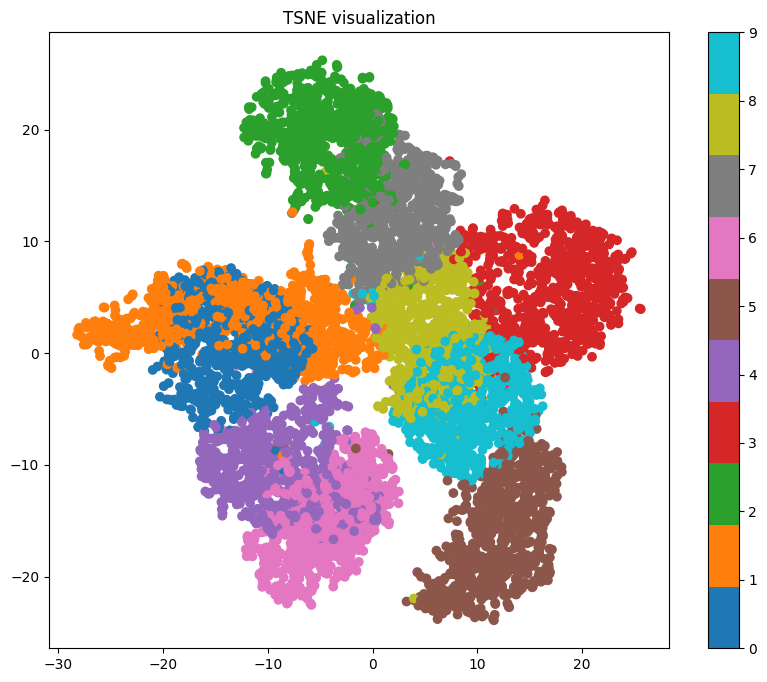

In [ ]:
visualize_tsne(test_features, test_labels)

## Efetuar o clustering e a avaliação

In [ ]:
kmeans_labels, hierarchical_labels = clustering_and_evaluation(test_features, test_labels)

Silhouette Score for KMeans: 0.3215269148349762
Silhouette Score for Hierarchical Clustering: 0.31499406695365906


## Plotar exemplos confusos

Cluster 0 has examples from multiple classes: [1 3 5]


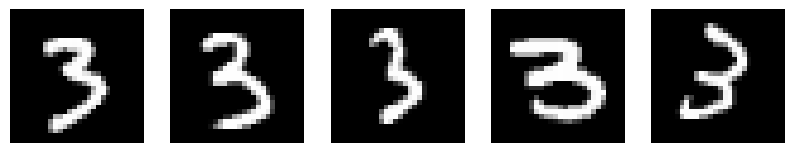

Cluster 1 has examples from multiple classes: [0 2 3 5 7 8 9]


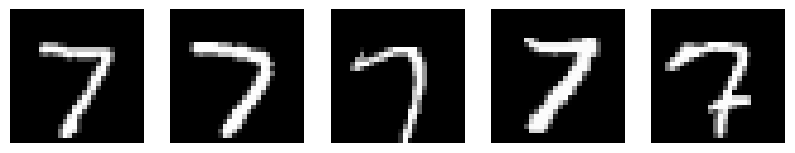

Cluster 2 has examples from multiple classes: [2 4 6 7 8 9]


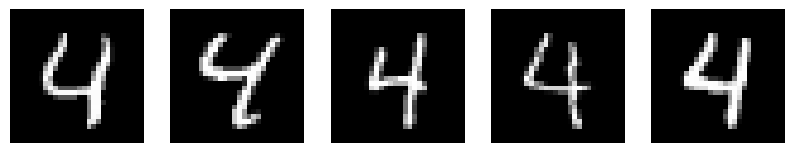

Cluster 3 has examples from multiple classes: [0 1 2 3 4 5 6 7 8 9]


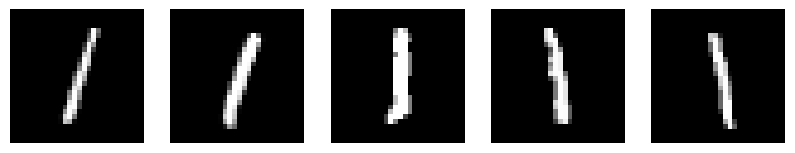

Cluster 4 has examples from multiple classes: [3 6 7 8]


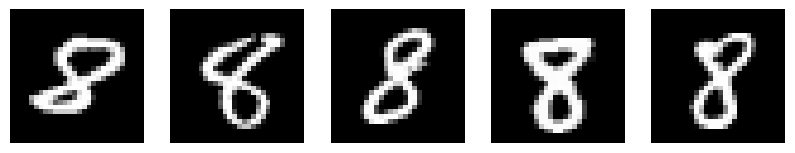

Cluster 5 has examples from multiple classes: [0 5 6]


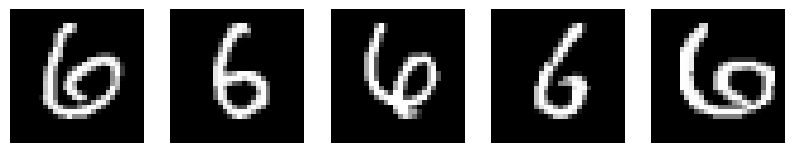

Cluster 6 has examples from multiple classes: [0 2 6 8]


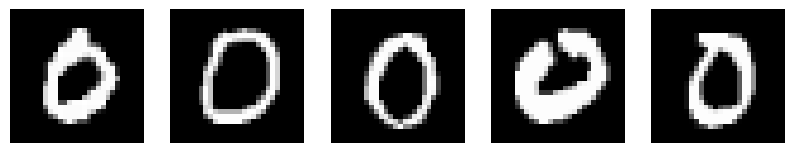

Cluster 7 has examples from multiple classes: [3 5 6 9]


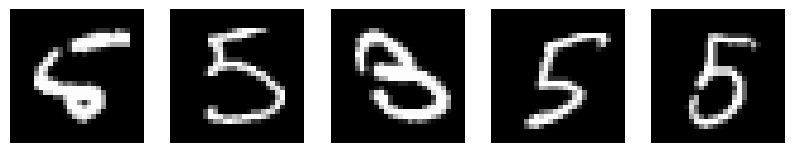

Cluster 8 has examples from multiple classes: [2 3 4 5 8 9]


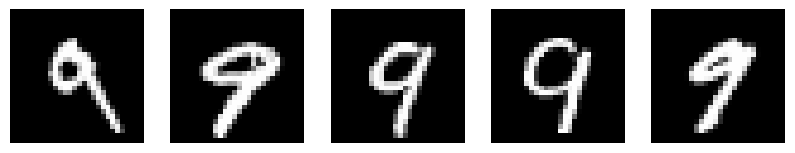

Cluster 9 has examples from multiple classes: [2 3 6 7 8]


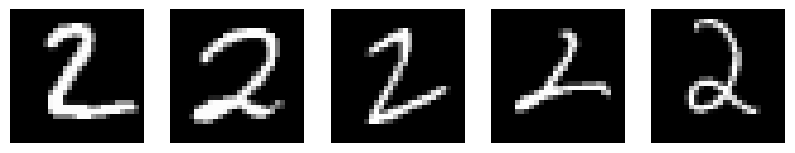

In [ ]:
plot_confusing_examples(test_images, test_labels, kmeans_labels)


## Plotar Gráfico em 3D

Use o scroll e o mouse para observar o plot. O gráfico é interativo, você pode girar para enxergar de qualquer lado, assim como pode aproximar ou afastar-se dele. Se passar o mouse sobre alguma casse, as informações desta classe aparecem escritas.

In [ ]:
class_names = {
    "Zero": 0, "Um": 1, "Dois": 2, "Três": 3, "Quatro": 4,
    "Cinco": 5, "Seis": 6, "Sete": 7, "Oito": 8, "Nove": 9
}

plot_3d_clusters(test_features, test_labels, class_names)

## Plotar visualização dos Clusters com ARI

_Use o scroll e o mouse para observar o plot. O gráfico é interativo, você pode girar para enxergar de qualquer lado, assim como pode aproximar ou afastar-se dele. Se passar o mouse sobre alguma casse, as informações desta classe aparecem escritas._

In [ ]:
compute_and_plot_ari(model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Adjusted Rand Index: 0.9393


# Conclusão

## Análise do T-SNE

Após plotar o T-SNE, podemos observar a separação dos dados de forma mais visual e reparar quais foram os principais pontos de dificuldade da rede neural para entender e classificar os dados da CNN:
- Pode-se observar que alguns clusters se separaram mais dos outros, como o cluster com a classe 6 e o cluster com a classe 2, que foram para pontos mais distantes do centro;
- As classes ainda apresentam elementos separados, o que mostra que o algoritmo teve dificuldade em separar as classes em agrupamentos bem definidos;
- A classe 1 se misturou bastante com a classe 0, assim como a classe 8  se misturou com a 9 e a classe 4 se misturou com a 6.

Os dados ficaram sobrepostos em alguns pontos, o que mostra que a IA teve dificuldade em encontrar características bem divergentes entre as classes, e isso deixou os clusters mais confusos.

Porém, mesmo com essas dificuldades, a IA conseguiu encontrar features que diferiam a maior parte de uma classe das outras, o que podemos notar pelos agrupamentos de clusters bem separados. As classes agrupadas sugerem que o TSNE conseguiu projetar as features de alta dimensão em um espaço 2D em que os pontos de mesma classe estão próximos.
Pode-se reparar também que o menor cluster é o da classe 2, o que dugere, por sua densidade, que existe uma menor variabilidade dos elementos desta classe, enquanto outras classes como a classe 1, que estão com uma densindade menor, provavelmente possuíam uma maior variabilidade de imagens.

## Análise da Pontuação de Silhueta

A pontuação de silhueta em 0.32 indica que os clusters formados por K-MEans são razoáveis, mas não são ótimos. Existe uma separação perceptível entre alguns, como observamos usando o TSNE, mas ainda não é o suficiente.

## Análise da Pontuação de Clustering Hierarquico

A pontuação de Clustering Hierarquico está semelhante a pontuação da silhueta, o que indica que o agrupamento hierárquico também está enfrentando desafios na separação dos clusters.

## Análise dos Exemplos Confusos

Ao analisar os exemplos confusos por cluster, podemos discernir quais clusters possuem várias classes:
- Cluster 0 (Classe 3): Durante o treinamento, se confundiu com os números 1 e 5, o que demonstra sua dificuldade em definir padrões para se diferenciar desses números. Assim como o cluster 5, é um dos clusters que se confundiu com o menor número de elementos;
- Cluster 1 (Classe 7): Se confundiu com os números 0, 2, 3, 5, 8 e 9. A similaridade nas linhas verticais e ângulos retos, especialmente quando o 7 é escrito com um traço horizontal na base, pode contribuir para essa confusão, assim como formas incompletas ou estilizações de 7 que se assemelham a outras classes.
- Cluster 2 (Classe 4): Se confundiu com os números 2, 6, 7, 8 e 9. A estrutura do 4, com interseções de linhas, pode ser confundida com o 9, que também possui uma interseção na parte superior. Além disso, formas semelhantes ao 2 e 7, especialmente quando escritos de forma irregular, podem aumentar a confusão.
- Cluster 3 (Classe 1): Se confundiu com todos os números (0, 2, 3, 4, 5, 6, 7, 8, 9). A simplicidade do 1, sendo uma linha reta, pode ser facilmente confundida com partes de outros números, como a linha vertical do 4 ou 7, e até mesmo segmentos de números mais curvados quando mal escritos.
- Cluster 4 (Classe 8): Se confundiu com os números 3, 6 e 7. A forma fechada do 8, com duas circunferências empilhadas, pode ser confundida com um 3 mal fechado ou com um 6 que apresenta uma forma similar na parte superior. Quando escrito de forma mais fluida, o 8 pode se parecer com um 7 curvado.
- Cluster 5 (Classe 6): Se confundiu com os números 0 e 5. A forma do 6, com um círculo fechado e uma linha vertical, pode se parecer com o 0 dependendo da caligrafia. Além disso, a estrutura do 6 pode ter semelhança com o 5, especialmente em dígitos mal escritos ou estilizados.
- Cluster 6 (Classe 0): Se confundiu com os números 2, 6 e 8. A forma circular do 0 pode ser confundida com o 6 e o 8, que também possuem partes circulares. O 2 pode se assemelhar ao 0 em certos estilos de escrita onde o loop do 2 é mais fechado.
- Cluster 7 (Classe 5): Se confundiu com os números 3, 6 e 9. A forma aberta do 5 pode ser confundida com o 6 e 9, que possuem partes circulares, especialmente em estilos de escrita mais arredondados. O 3 pode ser similar ao 5 na parte superior em certas grafias.
- Cluster 8 (Classe 9): Se confundiu com os números 2, 3, 4, 5 e 8. A estrutura do 9, com um círculo fechado na parte superior e uma linha vertical, pode se assemelhar ao 4 e 5. O 8 pode ser confundido com o 9 devido à forma similar na parte superior, enquanto o 2 e o 3 podem ter partes que lembram o 9.
- Cluster 9 (Classe 2): Se confundiu com os números 3, 6, 7 e 8. A forma do 2, com uma curva aberta e linha diagonal, pode se assemelhar ao 3 e 8. O 6 pode ser similar ao 2 dependendo da caligrafia, e o 7, quando escrito com uma curva, pode ser confundido com o 2.

**Conclusões:** Os clusters com melhor performance (menos confusão entre as imagens) foram os clusters 0 e 5, com as classes 3 e 6, respectivamente. Já os clusters com pior performance foram os clusters 3 e 1, das classes 1 e 7.  Pode-se observar que existiu uma tendência de confusão entre elementos com componentes visuais semelhantes, ou seja, números com muitos elementos retos e números com muitos elementos curvos se confundindo entre si.